<a href="https://colab.research.google.com/github/NeoNeuron/CCN2021_TUT/blob/main/large-scale.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>

---

# Large-Scale Network Model -- Resting-State Network

**Content Creator**: Yuxiu Shao

## Tutorial Objective
- Explore the dynamic **mean-field model** for large-scale *resting state* networks.

## Model Description

Consider $N$ excitatory neural assemblies with recurrent self-coupling $w$ and long range excitatory coupling $G$. 

![Model Scheme](https://github.com/NeoNeuron/CCN2021_TUT/blob/main/figures/model-scheme.png?raw=true)

Let $r_i$ and $I_i$ be the population-firing rate and total synaptic input current for population $i\in\{1,\ldots,N\}$. The firing rate $r_i$ is determined by the transfer function $F(I_i)$ given by:

$$
r_i = F(I_i) = \frac{aI_i - b}{1-\exp\left(-d\left(aI_i-b\right)\right)}
$$

where $a$ = 270 Hz/nA, $b$ = 108 Hz, $d$ = 0.154 sec.

The net current $I_i$ into population $i$ is given by 

$$
I_i = w J_N S_i + G J_N\sum_{j=1}^N C_{ij} S_j + I_{bi}
$$

where $J_N = 0.2609$ is the overall excitatory strength. The coupling parameters $w$ and $G$ scale the strengths of local and long-range interactions, respectively.

$I_{bi}$ is the background input into population $i$, which has a mean ($I_0$) and a noise component described by an Ornstein-Uhlenbeck(OU) process:

$$
\tau_0\frac{dI_{bi}}{dt} =-(I_{bi}-I_0)+\eta_i(t)\sqrt{\tau_0\sigma^2}
$$

where $I_0=0.3255$ nA, filter time constant $\tau_0=2$ ms, and noise amplitude $\sigma=0.02$ nA; $\eta(t)$ is a Gaussian white-noise with zero mean and unit standard deviation.

Assume that the *synaptic drive variable* $S_i$ for population $i$ obeys:

$$
\frac{dS_i}{dt} = F\left(I_i\right)\gamma\left(1-S_i\right)-\frac{1}{\tau_s}\,S_i
$$

where synaptic time constant $\tau_s$ = 100 ms and $\gamma$ = 0.641.

The synaptic drive $S_i$ is very indicative of the level of activity in population $i$ at time $t$. High levels of activity require rapid delivery of oxigenated blood to neuronal tissues that is captured by the **BOLD** signal of fMRI. The **BOLD** signal $B_i(t)$ is tipically modeled as a delayed *low-pass filtered* version of $S_i(t)$. We'll use the Boynton gamma function as the filter kernel:

$$
f_{bold}(t)=\left(\frac{t-o}{\tau_{bold}}\right)^{p-1}\,\frac{1}{(p-1)!}\,\exp\left(-\frac{t-o}{\tau_{bold}}\right) H(t-o)
$$

where $p=2$ is a shape parameter, $\tau_{bold}=1.25$ s is a timescale parameter and $o=2.25$ s is a delay parameter and $H(t-o)$ is the Heaviside function.

The **BOLD** signal $B(t)$ generated by $S_i(t)$ is computed by evaluating the causal convolution of $S_i(t)$ with filter kernel $f_{bold}(t)$:

$$
B_i(t) = \int_{-\infty}^t S_i(x)\,f_{bold}(t-x)\,dx
$$

With the proposed parameters the kernel $f_{bold}(t)$ is simply a gamma function starting at $t=o$:

$$
B_i(t) = \int_{-\infty}^{t-o} S_i(x) \,\frac{t-o-x}{\tau_{bold}}\,\exp\left(-\frac{t-o-x}{\tau_{bold}}\right) dx
$$

The Global Signal (GS) is the average BOLD signal:

$$
GS(t) = \frac{1}{N}\sum_{i=1}^N B_i(t)
$$

<!-- ** Time Averages ** -->

**References**
* Deco, G., Ponce-Alvarez, A., Mantini, D., Romani, G. L., Hagmann, P., & Corbetta, M. (2013). <a href="resources/2012.deco.jn.pdf"> Resting-state functional connectivity emerges from structurally and dynamically shaped slow linear fluctuations</a>. The Journal of Neuroscience, 33(27), 11239-11252.
* Yang, G. J., Murray, J. D., Repovs, G., Cole, M. W., Savic, A., Glasser, M. F., ... & Anticevic, A. (2014). <a href="resources/2014.yang.pnas.pdf">Altered global brain signal in schizophrenia</a>. Proceedings of the National Academy of Sciences, 111(20), 7438-7443.
* Anticevic, A., Gancsos, M., Murray, J. D., Repovs, G., Driesen, N. R., Ennis, D. J., ... & Corlett, P. R. (2012). ,<a href="resources/2012.anticevic.pnas.pdf">NMDA receptor function in large-scale anticorrelated neural systems with implications for cognition and schizophrenia</a>. Proceedings of the National Academy of Sciences, 109(41), 16720-16725.
* Wong K-F and Wang X-J (2006) A recurrent network mechanism for time integration in perceptual decisions. J. Neurosci 26, 1314-1328.

---

In [1]:
#@title Execute cell to initialize
# @markdown Initialize the notebook environment
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.labelsize'] = 16


In [2]:
#@title Figure function

def plot_connectivity(con_mat, labels, vmin=None, vmax=None, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(con_mat,interpolation='nearest',cmap='hot',vmin=vmin,vmax=vmax)
    ax.xaxis.tick_top()
    # set xticks and yticks
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # set xticklabels and yticklabels
    ax.set_xticklabels(labels, fontsize=7, rotation=90)
    ax.set_yticklabels(labels, fontsize=7)
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])
    plt.show()

def plot_S_dynamics(params, data_pack):
    fig, ax = plt.subplots(2,1,figsize=(10,8), sharex=True)
    tt = params['range_t']
    # heatmap
    N = data_pack['S'].shape[0]
    ax[0].pcolormesh(tt, np.arange(N),data_pack['S'])
    ax[0].set_ylabel('Node Index')

    [ax[1].plot(tt,ineuron) for ineuron in data_pack['S']]
    ax[1].set_ylabel(r'Synaptic Gating Variables($S$)')
    ax[1].set_xlabel(r'Time($s$)')
    plt.show()

In [3]:
#@title Data retrieval 
#@markdown This cell downloads the example dataset that we will use in this tutorial, stored in `load_data` as a `dict`.
import io
import requests
from scipy.io import loadmat
r = requests.get('https://raw.githubusercontent.com/NeoNeuron/CCN2021_TUT/main/data/Human_66.mat')
if r.status_code != 200:
  print('Failed to download data')
else:
  load_data = loadmat(io.BytesIO(r.content))


We first import the structural connectivity and the functional connectivity matrix. Note the sparse connectivity between brain areas.

In [4]:
orr=[1,3,7]
testmat = np.reshape(np.arange(81),(9,9))
testmat = testmat[orr,:]
# testmat = testmat[:,orr]
print(testmat)

[[ 9 10 11 12 13 14 15 16 17]
 [27 28 29 30 31 32 33 34 35]
 [63 64 65 66 67 68 69 70 71]]


(66, 66) (66, 66)


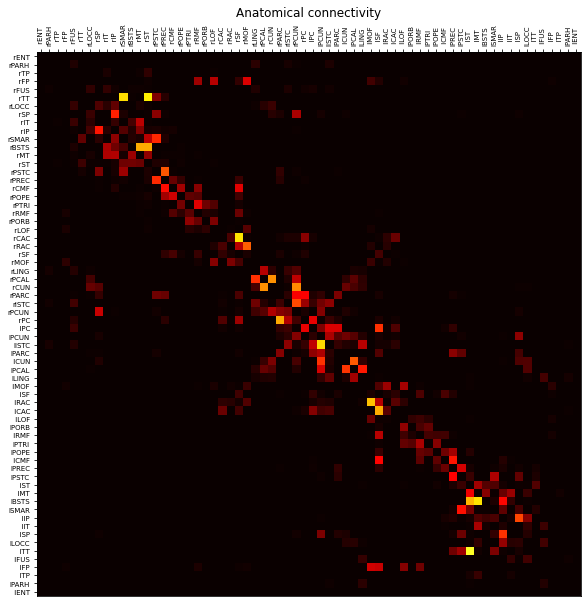

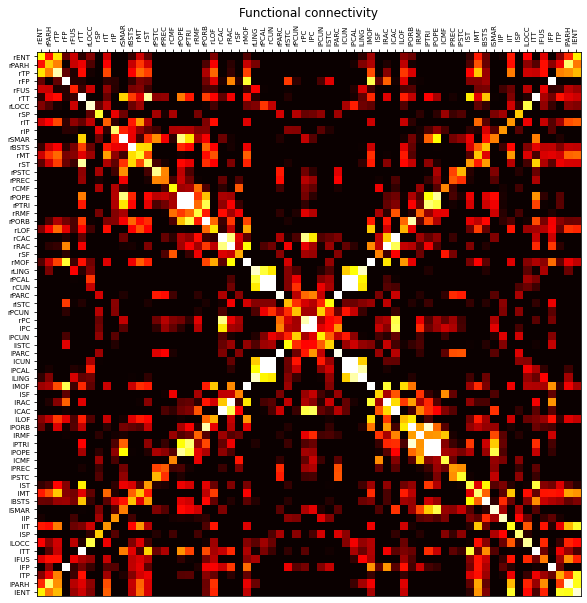

In [5]:
# Anatomical connectivity and functional connectivity
C, anat_labels, FC, order = np.array(load_data['C']), load_data['anat_lbls'],\
np.array(load_data['FC_emp']), np.array(load_data['Order'][0])-1

# resort anatomical connectivity and functional connectivity
C = C[order,:]
C = C[:,order]

# resort anatomical labels
anat_labels = anat_labels[order]

FC = FC[order,:]
FC = FC[:,order]

print(C.shape, FC.shape)

# plot connectivity weights matrix
plot_connectivity(C, anat_labels, vmin=0, vmax=.25, title='Anatomical connectivity')
plot_connectivity(FC, anat_labels, vmin=0, vmax=.25, title='Functional connectivity')

### Define functions

Let's define the transfer function $F(I_i)$, the BOLD signal kernel $f_{bold}(t)$ and BOLD transformation:

$$
F(I_i) = \frac{aI_i - b}{1-\exp\left(-d\left(aI_i-b\right)\right)}
$$

$$
f_{bold}(t)=\left(\frac{t-o}{\tau_{bold}}\right)^{p-1}\,\frac{1}{(p-1)!}\,\exp\left(-\frac{t-o}{\tau_{bold}}\right) H(t-o)
$$

In [6]:
def F(I, a=270., b=108., d=0.154):
    """F(I) for vector I"""
    
    return (a*I - b)/(1.-np.exp(-d*(a*I - b)))

def fbold(t, p=2., taub=1.25, o=2.25):
    """fbold(t) kernel for vector t"""
    kernel  = np.zeros_like(t)
    idx = t >= o
    kernel[idx] = ((t[idx] - o)/taub)**(p-1) / np.math.factorial(p-1) * np.exp(-(t[idx] - o)/taub)
    
    return kernel

Figuring out these two functions!

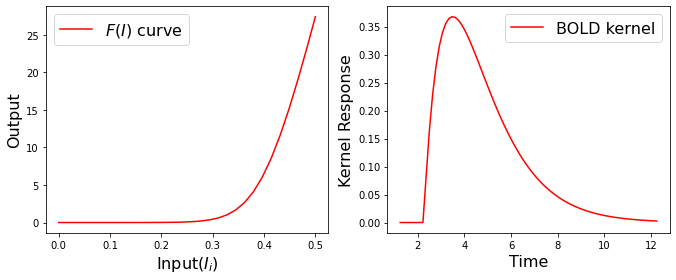

In [7]:
# show F(I) function curve
Iseries = np.linspace(0.0,0.5,30)
FIseries = F(Iseries)
fig,(axFI,axBOLD) = plt.subplots(1,2, figsize=(9.5,4))
axFI.plot(Iseries,FIseries,'red',linewidth=1.5,label=r'$F(I)$ curve')
axFI.set_xlabel(r'Input($I_i$)')
axFI.set_ylabel('Output')
axFI.legend()
# linear regime v.s. nonlinear regime

# BOLD signal -- temporal convolutional kernel 
tseries = np.linspace(1.25,12.25,80)
kernel = fbold(tseries)
# fig,axBOLD = plt.subplots(figsize=(4,4))
axBOLD.plot(tseries,kernel,'red',linewidth=1.5,label=r'BOLD kernel')
axBOLD.set_xlabel('Time')
axBOLD.set_ylabel('Kernel Response')
axBOLD.legend()
plt.tight_layout()


---

### Define simulator

Let's define the simulation kernel:

Here we first define some default parameters for the network and simulation, which can be changed later:

In [8]:
def default_pars(C, **kwargs):
    pars = {}
    # Network Parameters
    pars['C'] = C           # structural connectivity
    pars['w'] = 0.55        # self-excitation scaling factor
    pars['G'] = 3.5         # long-range scaling factor
    pars['JN'] = 0.2609     # overall excitatory strength [nA]
    pars['I0'] = 0.3        # 0.3255 # background current [nA]
    pars['tauS'] = 0.1      # Synaptic time constant [sec]
    pars['gamma'] = 0.641   # Saturation factor for gating variable
    pars['tau0'] = 0.002    # Noise time constant [sec]
    pars['sigma'] = 0.005   # Noise magnitude [nA]
    # Simulation Parameters
    pars['N'] = C.shape[0]  # number of nodes
    pars['T'] = 20.         # Total duration of simulation [sec]
    pars['dt'] = 0.001      # Simulation time step [sec]

    for k in kwargs:
        pars[k] = kwargs[k]
    
    pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of time points 
        
    return pars


In [9]:
def run_sim(pars, verbose=False,S=[], **kwargs):
    """S(t), r(t), Isyn(t), Ieta(t), b(t) for vector t"""
   
    # Retrieve parameters
    C = pars['C']
    N = pars['N']
    w, G = pars['w'], pars['G'] 
    JN = pars['JN']
    tauS, gamma = pars['tauS'], pars['gamma']
    I0, tau0, sigma = pars['I0'], pars['tau0'], pars['sigma']
    
    range_t = pars['range_t']
    nt = range_t.size
    dt = range_t[1] - range_t[0]
    
    # Initialize
    if (np.shape(S)[0]==0):
        S = np.zeros([N, nt])#np.zeros([N, nt])
    else:
        # continue simulation with previous state
        S[:,0]= S[:,-1]#+np.random.randn(N)*1e-2

    B = np.zeros([N, nt])
    r = np.zeros([N, nt])
    Isyn = np.zeros(N)#np.zeros([N, nt])
    
    # Set random seed
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])
    else:
        np.random.seed()
    
    # Initialize OU process
    Ieta = I0 + sigma*np.random.randn(N)
    noise = np.random.randn(N,nt)
    
    if verbose:
        print('Running...')
        progress = 0
    for idx in range(1, nt):
    
        # Total synaptic input
        Isyn = w*JN*S[:, idx-1] + G*JN*C@S[:,idx-1] + Ieta

        # Transfer function to get firing rate
        r[:, idx]  = F(Isyn)
    
        #---- Dynamical equations -------------------------------------------
    
        # Update Mean NMDA-mediated synaptic dynamics
        S[:, idx] = S[:, idx-1] + dt*(-S[:, idx-1]/tauS + (1-S[:, idx-1])*gamma*r[:, idx])
    
        # Update Ornstein-Uhlenbeck process
        Ieta = Ieta + (dt/tau0)*(I0-Ieta) + np.sqrt(dt/tau0)*sigma*noise[:,idx]

        if verbose:
            if 100.*(idx+1)/nt - progress >= 10:
                progress += 10
                print('\r',f'{progress:4d} %', end='')
    if verbose:
        print('')
    
    # Extract BOLD signal
    if verbose:
        print('extracting BOLD signal ...')
    fbold_vec = fbold(range_t)
    for idx in range(N):
        B[idx] = np.convolve(S[idx], fbold_vec)[:nt]
    if verbose:
        print('done!')
    z = {'S':S, 'r':r, 'Isyn': Isyn, 'Ieta':Ieta, 'B': B}
    return z

## Part 0: Testing things out

_Note: For comptuational expediency in this tutorial, we will focus on the dynamics of synaptic gating variables $(S)$ rather than BOLD signals $(B)$._

**1.** Simulate the model with default values. Plot the time course of $S$ for all nodes. Remove the intial part of the time course for $S$ which is the intial transient as $S$ approaches baseline values. What if the initial value of $S$ is set to be `S[:, 0]=np.ones(N)`? _(Coexistence of low-activity and high-activity states)_

Running...
  100 %
extracting BOLD signal ...
done!


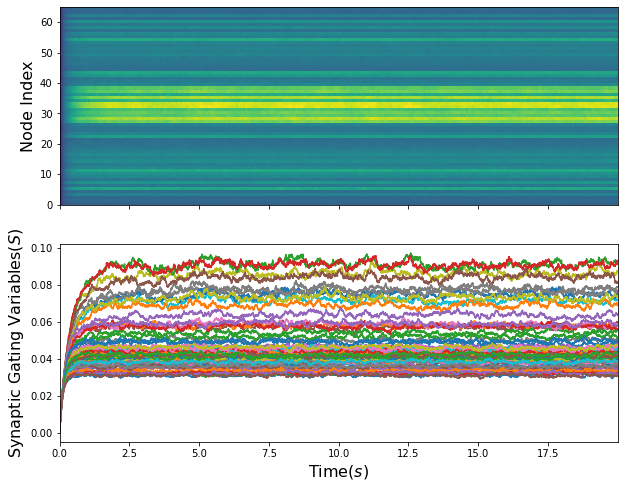

In [10]:
#  get default parameters
default_params=default_pars(C,)
# run simulation
DATAPACK = run_sim(default_params,verbose=True)

plot_S_dynamics(default_params, DATAPACK)

**2.** Half or double the scaling of long-range coupling $G$. Now plot $S$ in time for all nodes. What happened to the low-activity and high-activity baseline states? How could you test for instability of the baseline state?

Running...
  100 %
extracting BOLD signal ...
done!


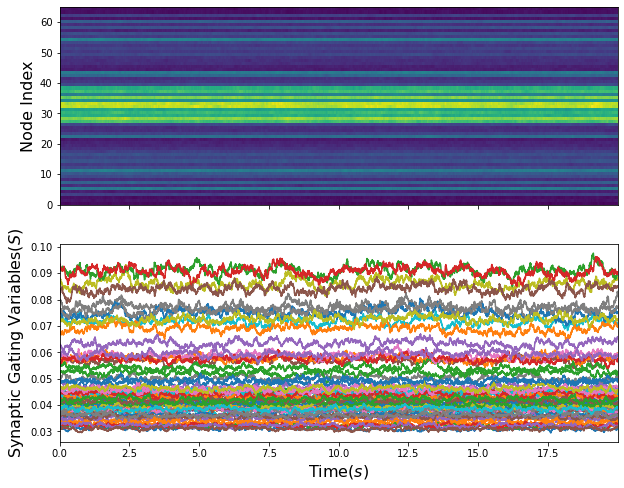

In [11]:
#  get default parameters
default_params=default_pars(C,)
params=default_params.copy()
params['G']*=1.0

# run simulation
DATAPACK = run_sim(params,verbose=True,S=DATAPACK['S'])

plot_S_dynamics(default_params, DATAPACK)


## Part 1: Functional Connectivity vs Structural Connectivity

_Note: Ideally we would calculate all metrics using BOLD ($B$). However, due to the sluggishness of the BOLD response, we will first use the synaptic gating variables ($S$) as our measure of neural activity._

**1.**  Generate and show the functional connectivity (FCsim) matrix from the neural signal ($S$) of the simulation with default values. _(resting sate with low firing activity, set `S[:, 0]=0`.)_

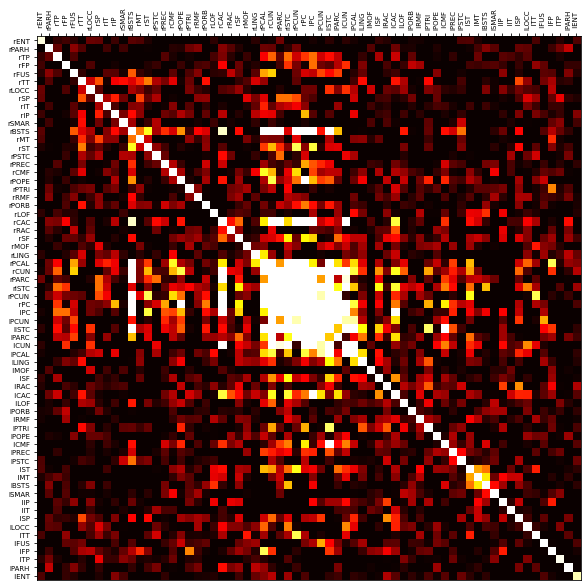

In [12]:
# FCsim use pearson correlation
N,nt = DATAPACK['S'].shape
muS= np.mean(DATAPACK['S'],axis=1)
muS = np.repeat(np.reshape(muS,(-1,1)),nt,axis=1)
corrS = DATAPACK['S']-muS
FCsim = corrS@corrS.T
plot_connectivity(FCsim, anat_labels, vmin=0, vmax=0.005)


**2.** Measure the correlations between FC, FCsim and SC matrices.

In [13]:
# corr between FC,FCsim
corrFCFCsim = FC*FCsim/np.sqrt(FC**2*FCsim**2)
corrFCFCsim = FC*FCsim/np.sqrt(FC**2*FCsim**2)

(-0.2, 0.5)

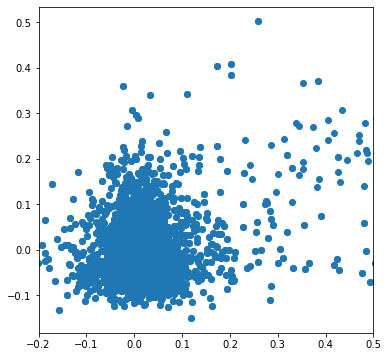

In [14]:
fig,ax = plt.subplots(figsize=(6, 6))
ax.scatter(FCsim.flatten()*50,FC.flatten())
ax.set_xlim([-0.2,0.5])

**3.** Investigate the eigenvectors of FC, FCsim and SC matrices. What do the dominant eigenvectors look like?

In [15]:
eigvFC,eigvecFC = np.linalg.eigh(FC)
eigvFCsim,eigvecFCsim = np.linalg.eigh(FCsim)
eigvSC,eigvecSC = np.linalg.eig(C)

Text(0.5, 0, 'Node Index')

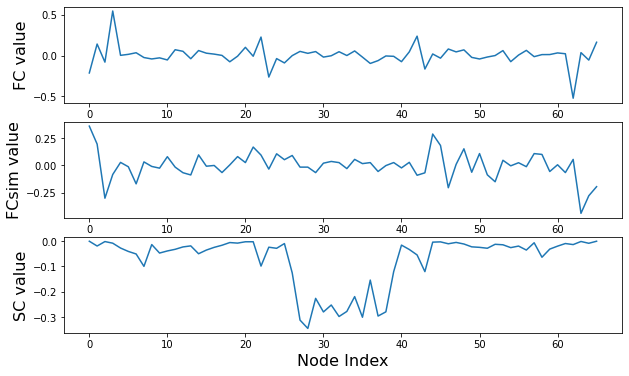

In [16]:
fig,ax = plt.subplots(3,1,figsize=(10, 6))
ax[0].plot(eigvecFC[:,0])
ax[1].plot(eigvecFCsim[:,0])
ax[2].plot(eigvecSC[:,0])
[ax[i].set_ylabel(f'{val:s} value') for i, val in enumerate(('FC', 'FCsim', 'SC'))]
ax[2].set_xlabel('Node Index')


## Part 2: Parameter Space Exploration

**1.** Do a 1-dimensional parameter sweep, first through $G$ and then $w$ without changing any other default values, characterize in terms of the following metrics:

* Correlation between FCsim and FC
* Mean local variance Mean($\text{Var}(S_i))$
* Global Signal variance $\text{Var}(GS)$
* Boundary of stability in parameter space (instable if at least one $S_i\geq S_{th}$).

What do you find?

In [ ]:
# write your own code here


**2.** Sweep thorugh the 2-dimensional parameterspace of $\{G,w\}$ and characterize these metrics. 

_Note: 2-dimensional parameter sweeps can be computationally intensive, so choose your resolution appropriately._

In [ ]:
# write your own code here


## Part 3: Timescales

**1.** Compare and contrasts results using two neural signals: synaptic activity ($S$) vs. BOLD ($B$). In particular, does the choice of neural signal affect the pattern of FCsim and the correlation between FCsim and FC? 

_Note: To use the BOLD signal, you will need a longer simulation duration and longer duration of initial time to remove transients in BOLD._

In [ ]:
# write your own code here
